
# How to Save the Pipeline Memory Efficiently

Our pipeline offers extensive insights into the dynamics of training and other intermediate results.  
When re-using the pipeline (with `.save` and `.load` functionality), this can create very large binary files, especially when working with large datasets.  

Therefore, the default way of saving the pipeline is by discarding most of the training dynamics and intermediate results.  
In this tutorial, we show:  
- Which data is kept and which is discarded. <br><br>
- The trade-offs in visualizing and evaluating a saved pipeline. <br><br>
- How to save the complete pipeline including all training dynamics and intermediate results. <br><br>

## Theory: What Data is Kept?

### Result Object
The main driver of memory is the `result` attribute and the `_datasets` (depending on the data size) in the pipeline and the trainer. 

In the `result` attribute, we save the following:  
- model
- adata_latent <br><br>
All other attributes are set to empty default values.
### Pipeline
Here we keep all attributes excpept:
- `.visualizer`
- `_datasets`
We remove the  `.visualizer`, because this stores plots which can be misleading when rerunning the pipeline and seeing old plots that do not fit the new data.    
We remove the `_datasets` attribute, because it is often uses the most memory.
All other attributes are kept. This is especially relevant for the `config` and the `_preprocessor`.  
Whenever you perform any pipeline step, it will use the initial config you passed when first creating the pipeline.  
The preprocessor is necessary because when running `predict` with new data, this should be preprocessed the same way as initially (e.g., which genes to keep, how the scalers were fitted, etc.).

### Trainer
We remove most attribute of the `_trainer` via the method `purge`.

**IMPORTANT**
> When calling `.save`, the `result` attribute is modified in-place (to avoid copies).  
> This means after calling `.save`, your current pipeline object does not contain information from the other result objects.  
> This applies to the pipeline object in current memory, not only to the pipeline object after loading.  
> If you want to avoid this, please run `.save(save_all=True)`.


## Practical Examples
### First we run a varix pipeline 

In [1]:
from autoencodix.utils.example_data import EXAMPLE_MULTI_SC
from autoencodix.configs.varix_config import VarixConfig
from autoencodix.configs.default_config import DataCase, DataConfig, DataInfo
import autoencodix as acx

my_config = VarixConfig(
    learning_rate=0.001,
    epochs=30,
    checkpoint_interval=5,
    default_vae_loss="kl",  # kl or mmd possible
    data_case=DataCase.MULTI_SINGLE_CELL,
)
print("\n")
print("Starting Pipeline")
print("-" * 50)
print("-" * 50)
varix = acx.Varix(
    data=EXAMPLE_MULTI_SC,
    config=my_config,
)
result = varix.run()



Starting Pipeline
--------------------------------------------------
--------------------------------------------------
in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
mudata: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Epoch 1 - Train Loss: 28.0271
Sub-losses: recon_loss: 28.0271, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 22.2071
Sub-losses: recon_loss: 22.2071, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 25.6951
Sub-losses: recon_loss: 25.6951, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 21.3873
Sub-losses: recon_loss: 21.3873, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 3 - Train Loss: 23.7502
Sub-losses: recon_loss: 23.7501, var_loss: 0.0001, anneal_factor: 0.0002, effective_beta_factor: 0.0000
Epoch 3 - Valid Loss: 20.3982
Sub-losses: recon_loss: 20.3982, var_loss: 0.0000, anneal_factor: 0.0002, effective_beta_factor: 0.0000
Epoch 4 - Train Loss: 22.7519
Sub-losses: recon_loss: 22.7518, var_loss: 0.0002, anneal_factor: 0.0003, effective_beta_factor: 0.0000
Epoch 4 - Valid Loss: 20.7051
Sub-losses: recon_loss: 20.7050,

#### Saving and Loading Explained

Here we first check the latent space (could be any other training dynamic) before saving.  
After saving, we see that the `result` object got cleaned and only `model`, `adata_latent`, and `embedding_evaluation` are kept.


In [2]:
ls_before_save = result.latentspaces.get(epoch=-1, split="test")
print("Length of latentspace before saving")
print(len(ls_before_save))
varix.save("varix_backup.pkl")
ls_after_save = result.latentspaces.get()
print("Length of latentspace after saving")
print(len(ls_after_save))

Length of latentspace before saving
200
Preprocessor saved successfully.
saving memory efficient
Pipeline object saved successfully.
Length of latentspace after saving
0


#### Implications for Visualization
We load the model and see the implications of this in `visualize`.


In [3]:
varix_loaded = acx.Varix().load("varix_backup.pkl")

Attempting to load a pipeline from ./varix_backup.pkl...
Pipeline object loaded successfully. Actual type: Varix
Preprocessor loaded successfully.


In [4]:
varix_loaded.visualize()

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/visualize/_general_visualizer.py:51: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Number of columns must be a positive integer, not 0
  warnings.warn(


<Figure size 0x500 with 0 Axes>

> Note that we code a `UserWarning`. This is expected, since it tells us that we cannot visualize loss plots anymore because the data for this is no longer in the result object.  
> However, we could run a predict step on the trained model to get some visualizations.


In [5]:
res_loaded = varix_loaded.predict(data=EXAMPLE_MULTI_SC)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
mudata: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
Processing 1 MuData objects: ['multi_sc']
Processing test split
Processing test modality: multi_sc
n_samples in format recon: 1000
train
n_samples from datatpackge: {'paired_count': 1000}


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/visualize/_general_visualizer.py:51: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Number of columns must be a positive integer, not 0
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:1000: UserWarning: No loss data found in results. Skipping loss curve visualization.
  warnings.warn(


Creating plots ...


<Figure size 0x500 with 0 Axes>

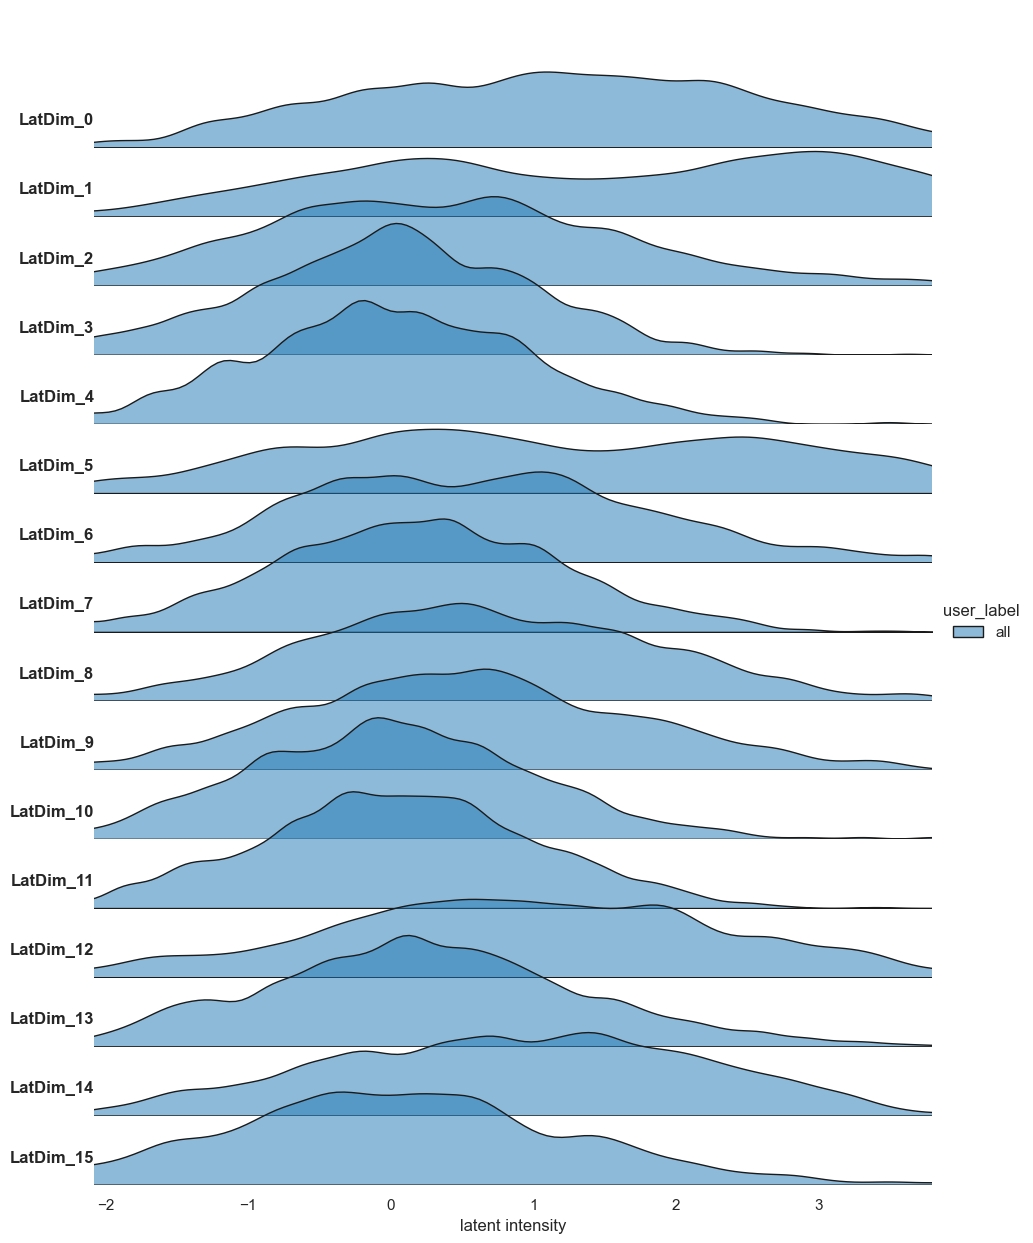

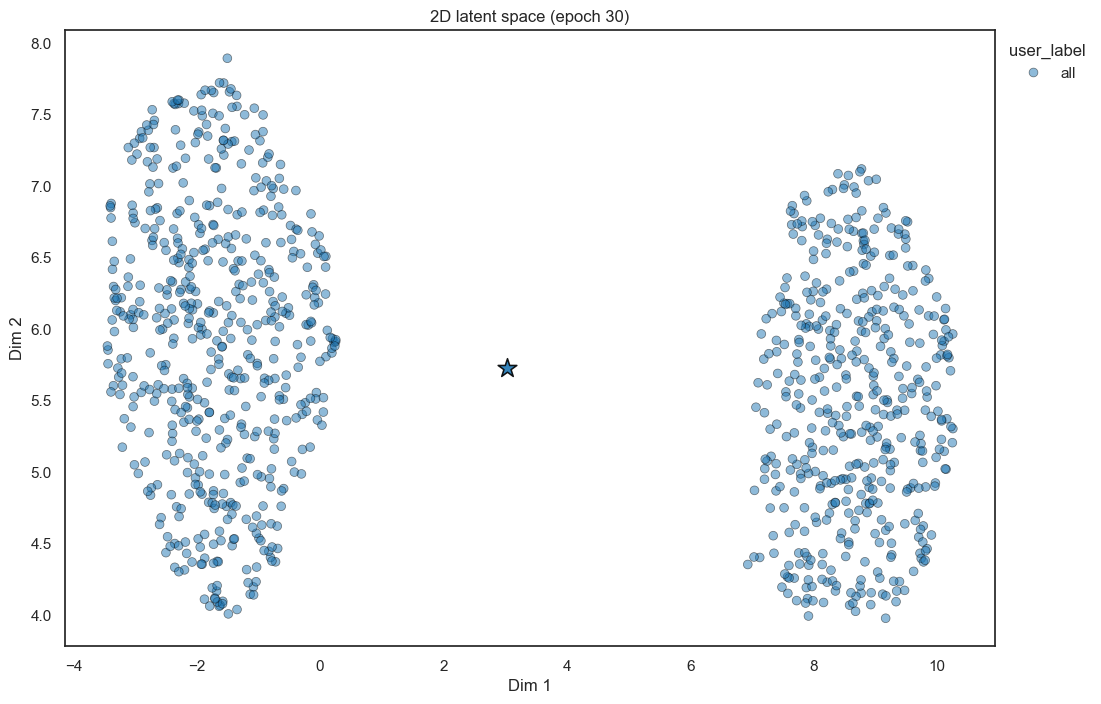

In [6]:
varix_loaded.visualize()
# we use test split here, because predict with new data is equal to test split
varix_loaded.show_result(split="test")

#### Implications for Evaluate
The evaluate step is not supported for this memory-efficient saving as of now, and you'll get the following warning and error:


In [7]:
res_eval = varix_loaded.evaluate(params=["rna:cell_type"])

Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: rna:cell_type


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/evaluate/_general_evaluator.py:98: UserWarning: Warning: No train split found in result datasets for 'use-split' evaluation. ML model cannot be trained without a train split. Switch to cross-validation (CV-5) instead.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This me

## How to Keep All Data
When you really want to investigate all training dynamics and results, we recommend setting `save_all=True`. See below:


In [8]:
from autoencodix.utils.example_data import EXAMPLE_MULTI_BULK

my_config = VarixConfig(
    learning_rate=0.001,
    epochs=30,
    checkpoint_interval=5,
    default_vae_loss="kl",  # kl or mmd possible
    data_case=DataCase.MULTI_BULK,
)
n_varix = acx.Varix(data=EXAMPLE_MULTI_BULK, config=my_config)
result_new = n_varix.run()
n_varix.save(file_path="new_varix.pkl", save_all=True)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: transcriptomics
anno key: proteomics
Epoch 1 - Train Loss: 27.2872
Sub-losses: recon_loss: 27.2872, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 21.5430
Sub-losses: recon_loss: 21.5430, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 26.5895
Sub-losses: recon_loss: 26.5894, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 22.5112
Sub-losses: recon_loss: 22.5112, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 3 - Train Loss: 25.5146
Sub-losses: recon_loss: 25.5145, var_loss: 0.0001, anneal_factor: 0.0002, effective_beta_factor: 0.0000
Epoch 3 - Valid Loss: 21.5901
Sub-losses: recon_loss: 21.5900, var_loss: 0.0000, anneal_factor: 0.0002, effective_beta_factor: 0.0000
Epoch 4 - Train Loss: 24.1691
Sub-losses: recon_loss: 24.168

Now we can load the pipeline and all intermediate data is kept.

In [9]:
loaded_all_varix = acx.Varix().load(file_path="new_varix.pkl")

Attempting to load a pipeline from ./new_varix.pkl...
Pipeline object loaded successfully. Actual type: Varix
Preprocessor loaded successfully.


In [10]:
loaded_all_varix.visualize()

Creating plots ...


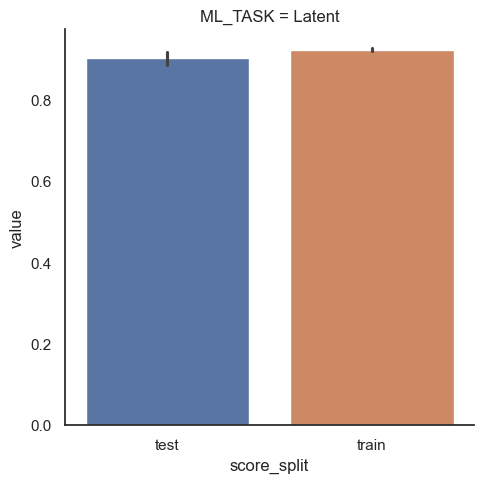

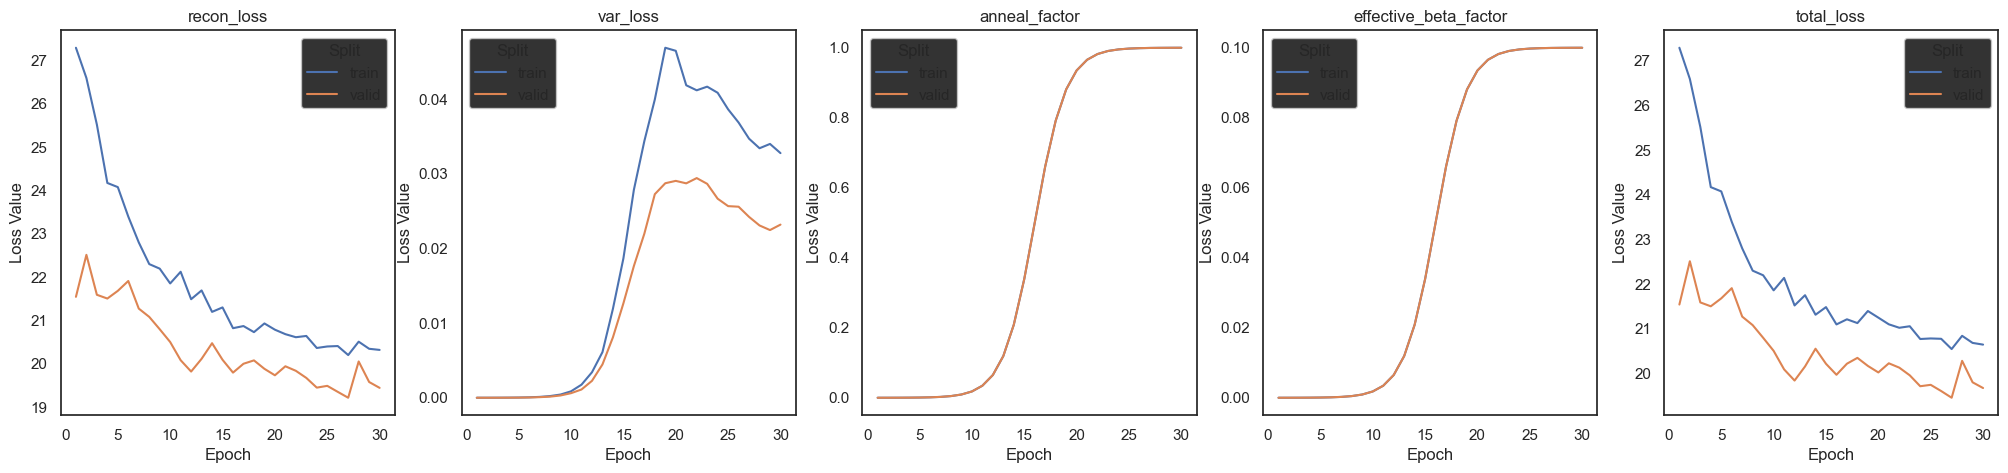

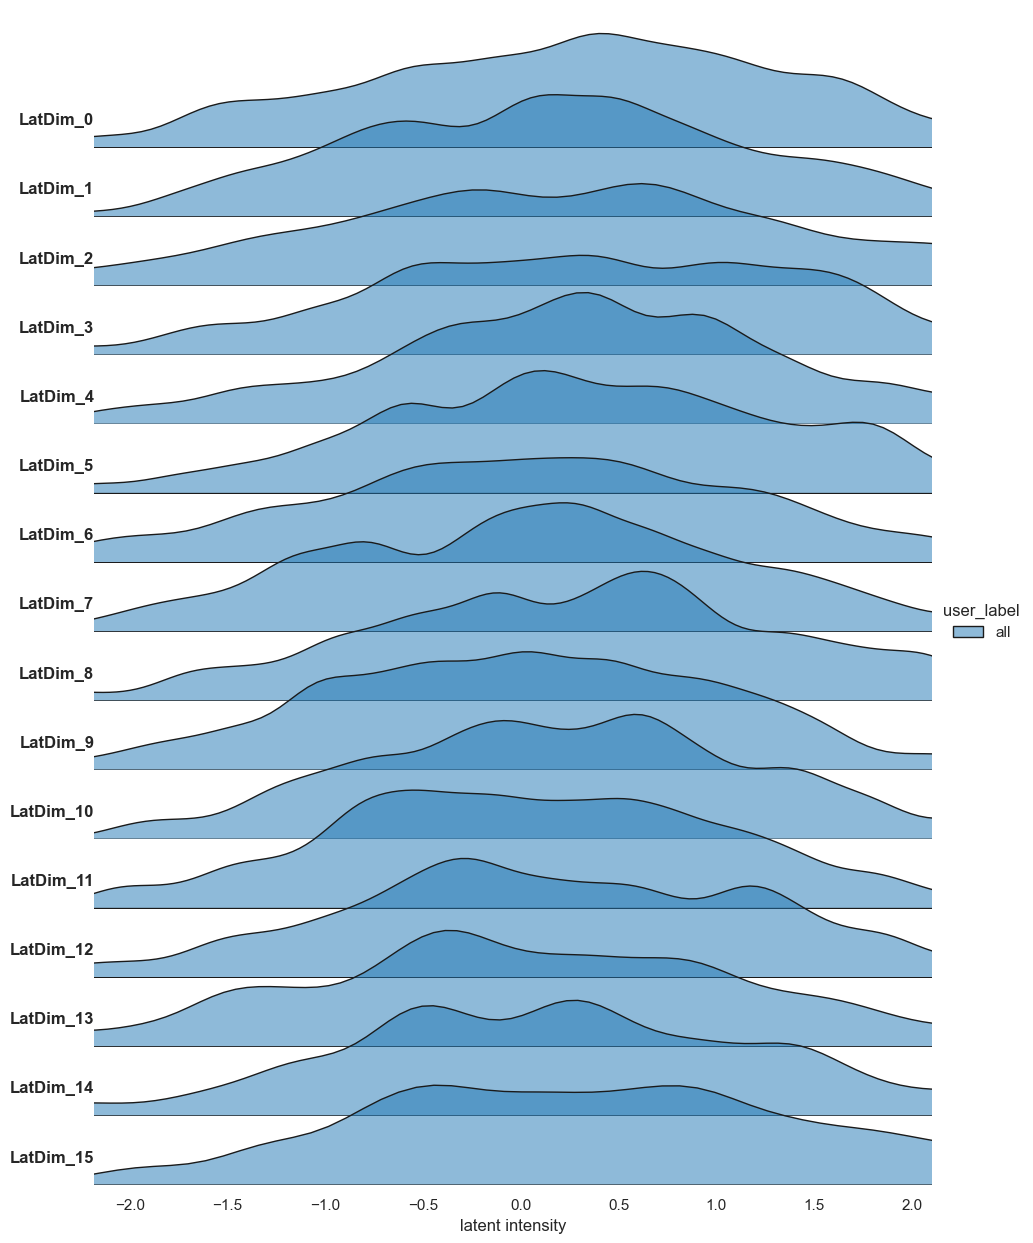

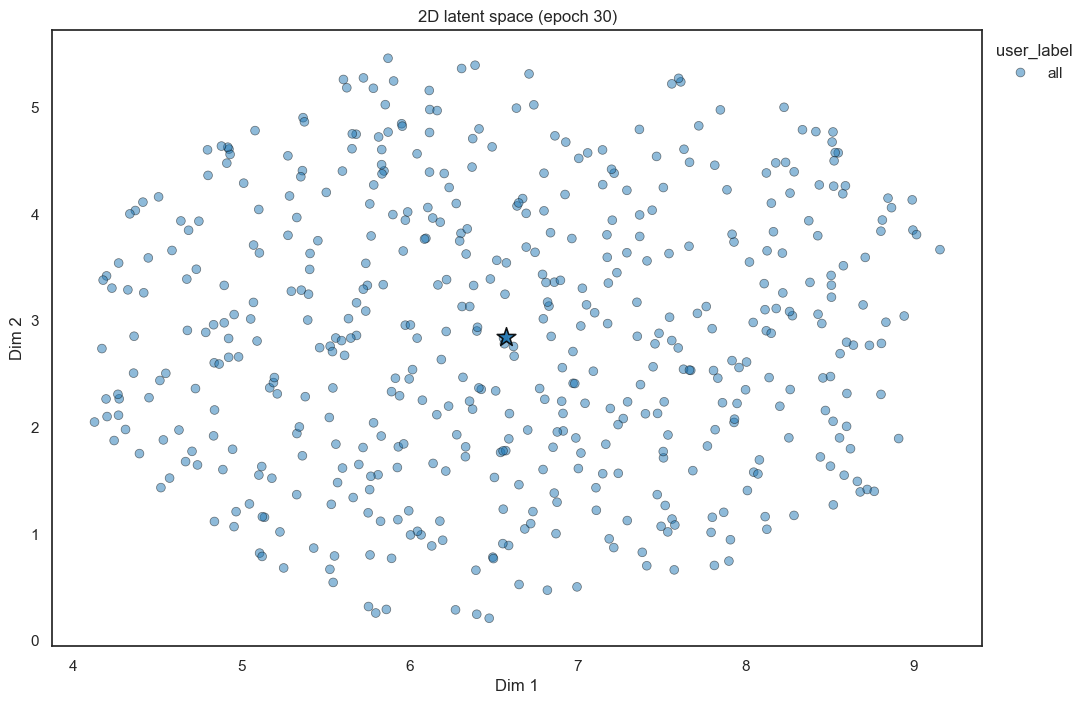

In [11]:
loaded_all_varix.show_result()

And we see that the loss plots from the initial training are still present.

## Implications for Ontix and XModalix
These two pipelines offer more/other visualizations.
### ❗❗ Requirements: Getting Tutorial Data for XModalixj ❗❗

You can use the following bash commands to download the data and set up the correct folder structure.  
**Assumption:** you are in the root of `autoencodix_package`.

```bash
mkdir -p data
cd data
wget "https://cloud.scadsai.uni-leipzig.de/index.php/s/bq64MaQyZGZfN64/download/XModalix-Tut-data.zip"
unzip XModalix-Tut-data.zip
```


### XModalix

In [12]:
import os
import autoencodix as acx

from autoencodix.configs.xmodalix_config import XModalixConfig
from autoencodix.configs.default_config import DataCase

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")

clin_file = os.path.join("data/XModalix-Tut-data/combined_clin_formatted.parquet")
rna_file = os.path.join("data/XModalix-Tut-data/combined_rnaseq_formatted.parquet")
img_root = os.path.join("data/XModalix-Tut-data/images/tcga_fake")

xmodalix_config = XModalixConfig(
    checkpoint_interval=5,
    class_param="CANCER_TYPE_ACRONYM",
    epochs=30,
    latent_dim=8,
    requires_paired=False,
    pretrain_epochs=2,
    data_case=DataCase.IMG_TO_BULK,
    data_config=DataConfig(
        annotation_columns=["CANCER_TYPE_ACRONYM"],
        data_info={
            "img": DataInfo(
                file_path=img_root,
                data_type="IMG",
                scaling="MINMAX",
                translate_direction="to",
                pretrain_epochs=2,
                # extra_anno_file=imganno_file,
            ),
            "rna": DataInfo(
                file_path=rna_file,
                data_type="NUMERIC",
                scaling="MINMAX",
                translate_direction="from",
            ),
            "anno": DataInfo(file_path=clin_file, data_type="ANNOTATION", sep="\t"),
        },
    ),
)

xmodalix = acx.XModalix(config=xmodalix_config)
result = xmodalix.run()
outpath = os.path.join("tutorial_res", "xmodalix.pkl")
xmodalix.save(file_path=outpath)



Changed to: /Users/maximilianjoas/development/autoencodix_package
reading parquet: data/XModalix-Tut-data/combined_rnaseq_formatted.parquet
reading parquet: data/XModalix-Tut-data/combined_clin_formatted.parquet
Given image size is possible, rescaling images to: 64x64
Successfully loaded 3230 images for img
anno key: rna
anno key: img
Converting 2261 images to torch.float32 tensors...
Converting 646 images to torch.float32 tensors...
Converting 323 images to torch.float32 tensors...
key: train, type: <class 'dict'>
key: valid, type: <class 'dict'>
key: test, type: <class 'dict'>
Dataset has UNPAIRED samples → using CoverageEnsuringSampler (2261 paired + 225 unpaired)
Dataset has UNPAIRED samples → using CoverageEnsuringSampler (323 paired + 32 unpaired)
Check if we need to pretrain: multi_bulk.rna
pretrain epochs : 2
Starting Pretraining for: multi_bulk.rna with <class 'autoencodix.trainers._general_trainer.GeneralTrainer'>
Epoch 1 - Train Loss: 4.2399
Sub-losses: recon_loss: 4.2399, v

Now we can load the pipeline again

In [13]:
xmodalix_loaded = acx.XModalix.load(outpath)

Attempting to load a pipeline from tutorial_res/xmodalix.pkl...
Pipeline object loaded successfully. Actual type: XModalix
Preprocessor loaded successfully.


Since we used memory efficient saving, we did not save the data, thus we need to run preprocessing again, this will read and preprocess the files defined in the config.

In [14]:
xmodalix_loaded.preprocess()


reading parquet: data/XModalix-Tut-data/combined_rnaseq_formatted.parquet
reading parquet: data/XModalix-Tut-data/combined_clin_formatted.parquet
Given image size is possible, rescaling images to: 64x64
Successfully loaded 3230 images for img
anno key: rna
anno key: img
Converting 2261 images to torch.float32 tensors...
Converting 646 images to torch.float32 tensors...
Converting 323 images to torch.float32 tensors...
key: train, type: <class 'dict'>
key: valid, type: <class 'dict'>
key: test, type: <class 'dict'>


No we can use the trained model to predict again:

In [15]:
# now you can use the model to predict with a different pair again:

r = xmodalix_loaded.predict(from_key="rna", to_key="img")

Prediction complete.
Processing latent space results into a single AnnData object...
Identified source modality for latent space: 'multi_bulk.rna'
  - Added 20 source feature IDs to .uns
Finished processing latent results.


In [16]:
xmodalix_loaded.visualize()

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/visualize/_xmodal_visualizer.py:55: UserWarning: No loss data: This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.
  warnings.warn(


Creating plots ...
Absolute loss plot not found in the plots dictionary
This happens, when you did not run visualize() or if you saved and loaded the model with `save_all=False`


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
 

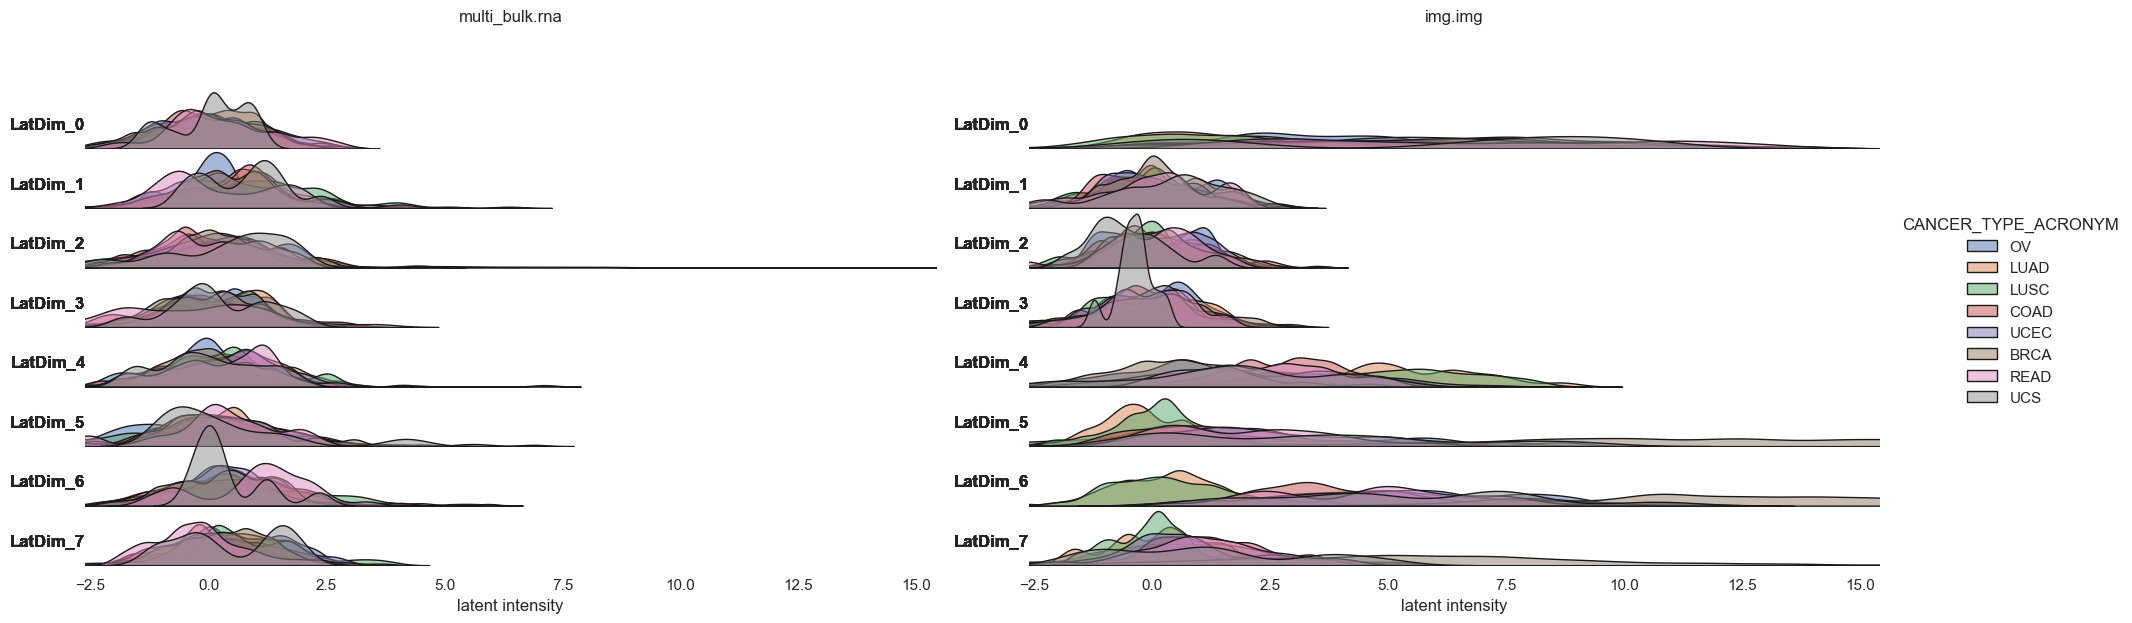

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
 

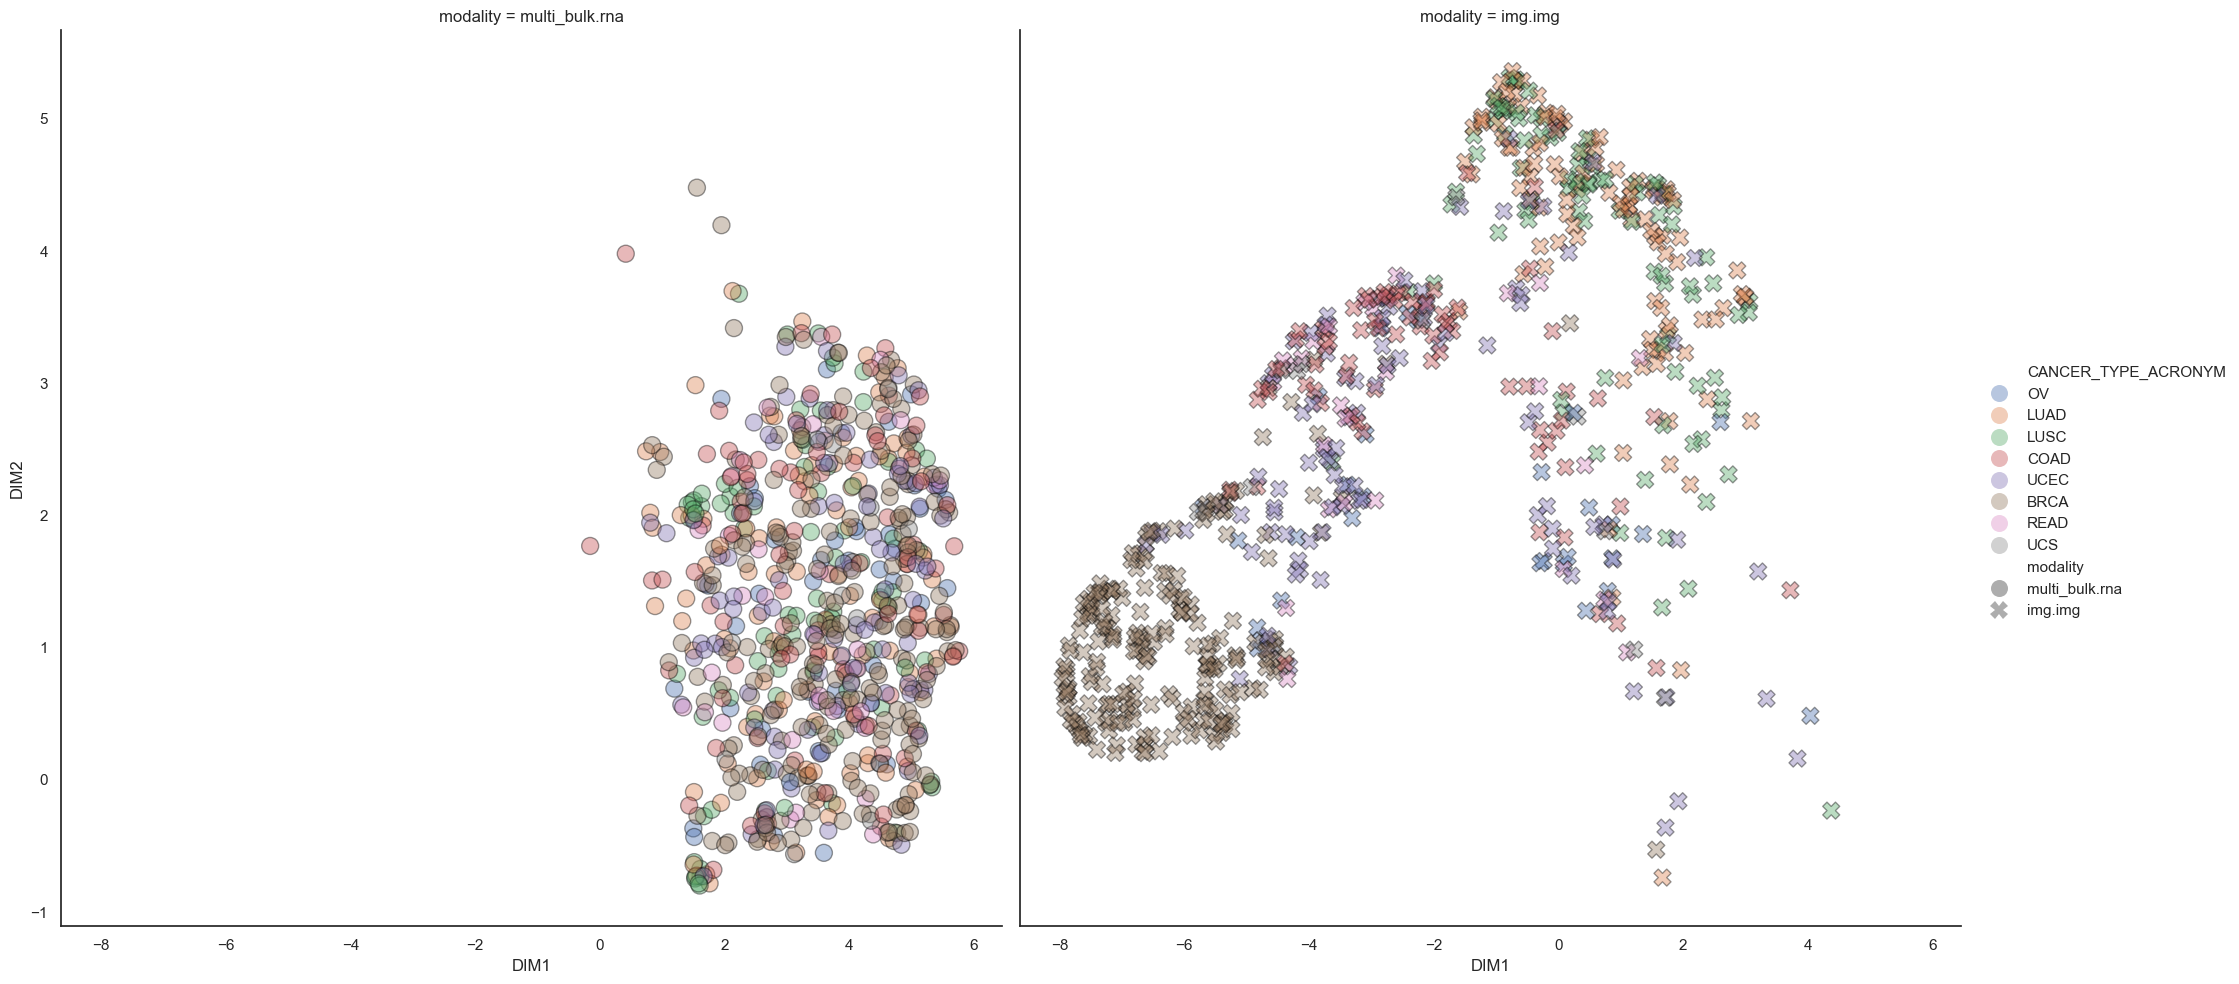

In [17]:
xmodalix_loaded.show_result()

### Ontix

In [18]:
import autoencodix as acx
from autoencodix.configs.default_config import DefaultConfig
from autoencodix.configs.ontix_config import OntixConfig

from autoencodix.utils.example_data import (
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA


ont_lvl1 = dict()
ont_lvl2 = dict()

ont_lvl1["pwy-1"] = ["sub-pwy-1", "sub-pwy-2"]
ont_lvl1["pwy-2"] = ["sub-pwy-2"]
ont_lvl1["pwy-3"] = ["sub-pwy-1", "sub-pwy-3"]
# first third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-1"] = processed_data.train.feature_ids[
    : int(len(processed_data.train.feature_ids) / 3)
]
# second third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-2"] = processed_data.train.feature_ids[
    int(len(processed_data.train.feature_ids) / 3) : int(
        2 * len(processed_data.train.feature_ids) / 3
    )
]
# last third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-3"] = processed_data.train.feature_ids[
    int(2 * len(processed_data.train.feature_ids) / 3) : int(
        len(processed_data.train.feature_ids)
    )
]

# ont_lvl2["sub-pwy-1"] = ["gene-1", "gene-2"]
# ont_lvl2["sub-pwy-2"] = ["gene-3", "gene-4"]
# ont_lvl2["sub-pwy-3"] = ["gene-2", "gene-6"]

ontology_tuple = (ont_lvl1, ont_lvl2)

# Write each dictionary in ontology_tuple to a separate text file
for i, ont_dict in enumerate(ontology_tuple):
    file_name = f"ontology_level_{i + 1}.txt"
    with open(file_name, "w") as f:
        for key, values in ont_dict.items():
            for value in values:
                f.write(f"{value}\t{key}\n")
print("Ontology dictionaries written to ontology_level_1.txt and ontology_level_2.txt")

ont_files = ["ontology_level_1.txt", "ontology_level_2.txt"]

Ontology dictionaries written to ontology_level_1.txt and ontology_level_2.txt


In [19]:
ontix = acx.Ontix(
    ontologies=ont_files,
    sep="\t",
    config=OntixConfig(epochs=30, learning_rate=0.005, n_layers=1),
    data=processed_data,
)
result_onitx = ontix.run()

Ontix checks:
All possible feature names length: 30
Feature order length: 30
Feature names without filtering: 30
Mask layer 0 with shape torch.Size([3, 3]) and 5.0 connections
Mask layer 1 with shape torch.Size([30, 3]) and 30.0 connections
Latent Dim: 3
Epoch 1 - Train Loss: 1222.9162
Sub-losses: recon_loss: 1222.9161, var_loss: 0.0001, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 1200.1228
Sub-losses: recon_loss: 1200.1227, var_loss: 0.0002, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 1194.1082
Sub-losses: recon_loss: 1194.1077, var_loss: 0.0005, anneal_factor: 0.0001, effective_beta_factor: 0.0001
Epoch 2 - Valid Loss: 1162.7967
Sub-losses: recon_loss: 1162.7958, var_loss: 0.0008, anneal_factor: 0.0001, effective_beta_factor: 0.0001
Epoch 3 - Train Loss: 1148.2329
Sub-losses: recon_loss: 1148.2304, var_loss: 0.0024, anneal_factor: 0.0002, effective_beta_factor: 0.0002
Epoch 3 - Valid Loss: 1108.9914
Sub-losses: recon_loss:

In [20]:
ontix.save(file_path="ontix_backup.pkl")


Preprocessor saved successfully.
saving memory efficient
Ontix checks:
All possible feature names length: 30
Feature order length: 30
Feature names without filtering: 30
Mask layer 0 with shape torch.Size([3, 3]) and 5.0 connections
Mask layer 1 with shape torch.Size([30, 3]) and 30.0 connections
Latent Dim: 3
Pipeline object saved successfully.


In [21]:
ontix_loaded = acx.Ontix(ontologies=ont_files).load(file_path="ontix_backup.pkl")

Attempting to load a pipeline from ./ontix_backup.pkl...
Pipeline object loaded successfully. Actual type: Ontix
Preprocessor loaded successfully.


In [22]:
pred_res = ontix_loaded.predict(EXAMPLE_PROCESSED_DATA)

In [23]:
ontix_loaded.visualize()

ontix_loaded.evaluate(params=["cluster"])

Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: cluster
Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: cluster


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/visualize/_general_visualizer.py:51: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Number of columns must be a positive integer, not 0
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/evaluate/_general_evaluator.py:98: UserWarning: Warning: No train split found in result datasets for 'use-split' evaluation. ML model cannot be trained without a train split. Switch to cross-validation (CV-5) instead.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipe

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={})
preprocessed_data: Tensor of shape (0,)
model: OntixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=None, valid=None, test=None)
new_datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x31a229240>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x31a332fb0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x31a3331f0>)
adata_latent: AnnData object with n_obs × n_vars = 201 × 3
    uns: 'var_names'
final_reconstruction: None
sub_results: None
sub_reconstructions: None
embedding_evaluation:   cv_run score_split CLINIC_PARAM       metric     value  \
0   CV_1        te

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:1000: UserWarning: No loss data found in results. Skipping loss curve visualization.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 3)
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original er

Creating plots ...


<Figure size 0x500 with 0 Axes>

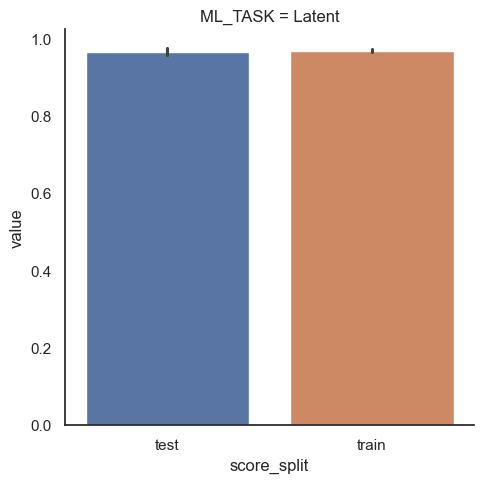

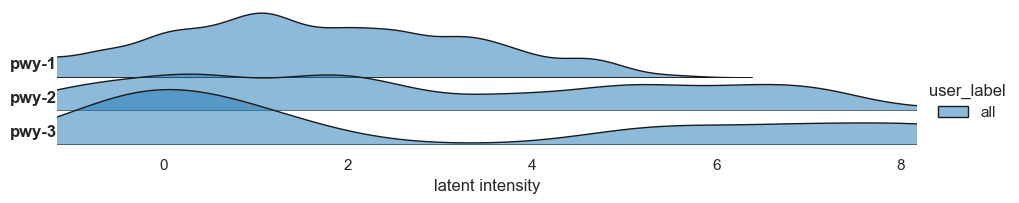

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 3)
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 3)
  warnings.warn(


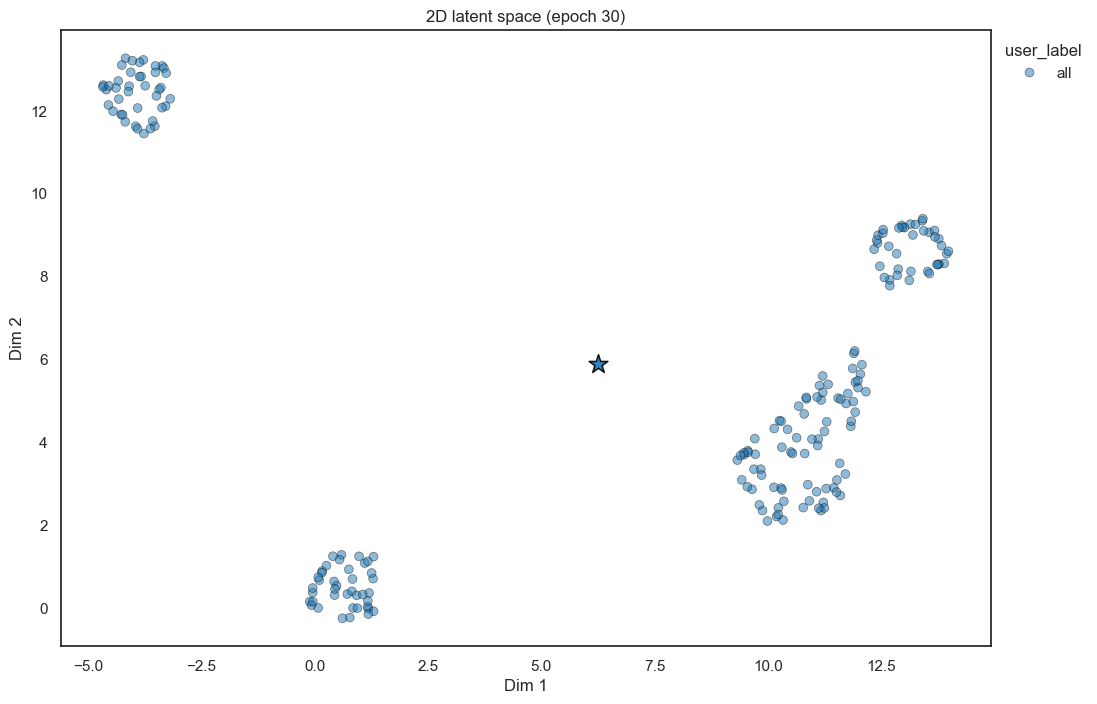

In [24]:
ontix_loaded.show_result()